In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from tqdm.auto import tqdm

In [2]:
import shift_analysis

Read the dataset, and remove rows containing covid data for regions / continents instead of just countries

In [3]:
df = pd.read_csv('datasets/owid-covid-data.csv')
df = df[df['continent'].notna()]

print(f'{len(df)} rows')
print('Dataframe columns')
print(df.columns)

126075 rows
Dataframe columns
Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vac

In [4]:
clean_df = df.copy()
iso_codes = df['iso_code'].to_numpy()
iso_codes = np.unique(iso_codes)
print('Country codes in dataset')
print(iso_codes)

Country codes in dataset
['ABW' 'AFG' 'AGO' 'AIA' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ATG' 'AUS' 'AUT'
 'AZE' 'BDI' 'BEL' 'BEN' 'BES' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR'
 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL'
 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COK' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CUW'
 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI'
 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FLK' 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO'
 'GGY' 'GHA' 'GIB' 'GIN' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUY'
 'HKG' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IMN' 'IND' 'IRL' 'IRN' 'IRQ' 'ISL'
 'ISR' 'ITA' 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA'
 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX'
 'LVA' 'MAC' 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEX' 'MHL' 'MKD' 'MLI' 'MLT'
 'MMR' 'MNE' 'MNG' 'MOZ' 'MRT' 'MSR' 'MUS' 'MWI' 'MYS' 'NAM' 'NCL' 'NER'
 'NGA' 'NIC' 'NIU' 'NLD' 'NOR' 'NPL' 'NRU' 'NZL' 'OMN' 'OWID_CYN'
 'OWID_KOS' 'PAK' 'PAN' 'PCN' 'PE

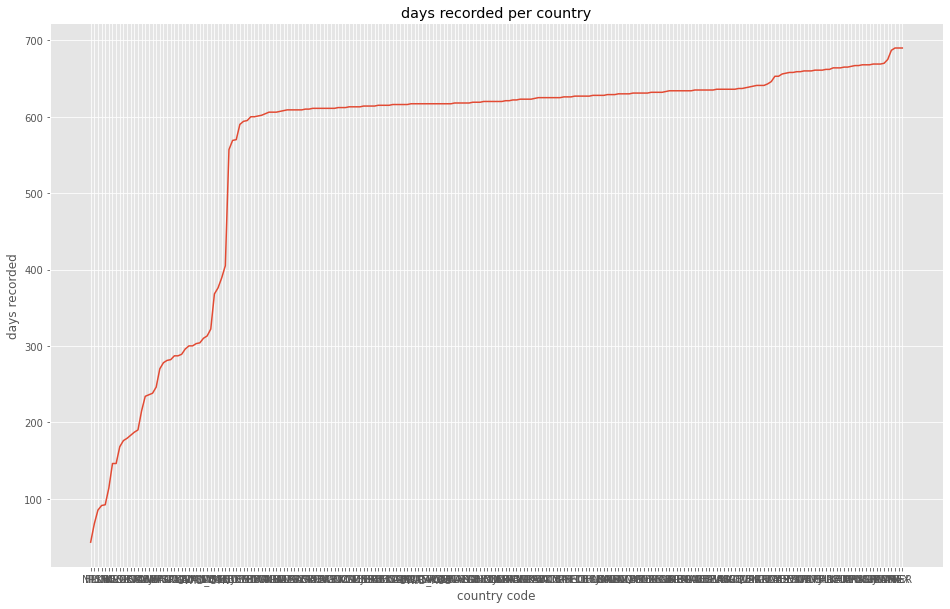

In [5]:
plt.style.use('ggplot')
plt.figure(figsize=(16,10))
durations = []

for iso_code in iso_codes:
    iso_df = df[df['iso_code'] == iso_code]
    duration = len(iso_df)
    durations.append(duration)

durations = np.array(durations)
indexes = np.argsort(durations)
countries = iso_codes[indexes]
durations = durations[indexes]

plt.title('days recorded per country')
plt.ylabel('days recorded')
plt.xlabel('country code')
plt.plot(countries, durations)


Lag the covid cases behind the number of deaths from 0 to 30 days, and Get the pearsons correlation between weekly smoothed deaths and weekly smoothed cases for each lag value

In [6]:
corr_map = shift_analysis.covariances(df, shift_start=0, shift_end=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Plot pearsons correlation vs days lagged

Deaths follow cases most closely with a 14 day lag


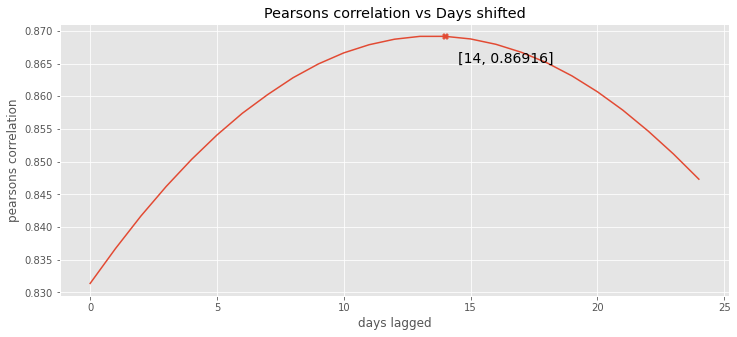

In [7]:
shifts = list(corr_map.keys())
corrs = [x[0][1] for x in list(corr_map.values())]
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.plot(shifts, corrs)

best_index = np.argmax(corrs)
best_shift = shifts[best_index]
best_corr = corrs[best_index]

plt.title('Pearsons correlation vs Days shifted')
plt.scatter([best_shift], [best_corr], marker='X')
plt.ylabel('pearsons correlation')
plt.xlabel('days lagged')
plt.annotate(
    str([int(best_shift), round(best_corr, 5)]),
    [best_shift + 0.5, best_corr - 0.004],
    fontsize=14
)

print(f'Deaths follow cases most closely with a {best_shift} day lag')

According to the graph, the number of deaths most closely follows the number of cases 14 days prior. This is somewhat lower than the median time reported by medical literiture (https://www.drugs.com/medical-answers/covid-19-symptoms-progress-death-3536264/), which reports it as around 18.5 days.

In [8]:
country_dfs = []
for iso_code in tqdm(iso_codes):
    country_df = df[df['iso_code'] == iso_code]
    cases = country_df['new_cases_smoothed'].fillna(0).to_numpy()
    deaths = country_df['new_deaths_smoothed'].fillna(0).to_numpy()
    # print(len(country_df))
    
    assert best_shift > 0
    shifted_cases = cases[:-best_shift]
    shifted_deaths = deaths[best_shift:]
    country_df = country_df[:-best_shift]
    # print(len(country_df), len(cases), len(deaths))
    
    country_df['shifted_cases'] = shifted_cases
    country_df['shifted_deaths'] = shifted_deaths
    country_dfs.append(country_df)

clean_df = pd.concat(country_dfs)
display(clean_df)

  0%|          | 0/224 [00:00<?, ?it/s]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,shifted_cases,shifted_deaths
6020,ABW,North America,Aruba,2021-03-29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,0.000,0.000
6021,ABW,North America,Aruba,2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,0.000,0.000
6022,ABW,North America,Aruba,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,0.000,0.000
6023,ABW,North America,Aruba,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,0.000,0.000
6024,ABW,North America,Aruba,2021-04-02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134647,ZWE,Africa,Zimbabwe,2021-11-02,133047.0,40.0,46.143,4683.0,4.0,1.286,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,46.143,1.000
134648,ZWE,Africa,Zimbabwe,2021-11-03,133091.0,44.0,40.429,4684.0,1.0,1.286,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,40.429,0.714
134649,ZWE,Africa,Zimbabwe,2021-11-04,133112.0,21.0,33.143,4685.0,1.0,1.429,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,33.143,0.714
134650,ZWE,Africa,Zimbabwe,2021-11-05,133112.0,0.0,26.571,4685.0,0.0,1.429,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,26.571,0.714


In [9]:
new_corr_map = shift_analysis.covariances(
    clean_df, shift_start=0, shift_end=10,
    cases_column='shifted_cases', deaths_column='shifted_deaths'
)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'days lagged')

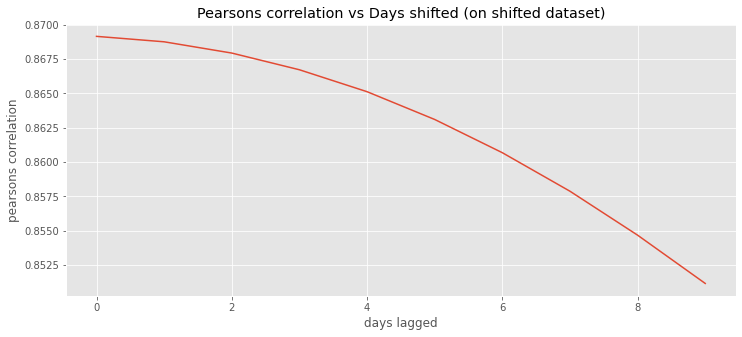

In [10]:
shifts = list(new_corr_map.keys())
corrs = [x[0][1] for x in list(new_corr_map.values())]
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.plot(shifts, corrs)

plt.title('Pearsons correlation vs Days shifted (on shifted dataset)')
plt.ylabel('pearsons correlation')
plt.xlabel('days lagged')

# print(f'Deaths follow cases most closely with a {best_shift} day lag')